In [1]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe
from sublimpy import extrautils

In [2]:
# DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

DATES = pd.Series(['20230418', '20230419'])
DATE_LOCAL = '20230418'

# DATES = pd.Series(['20230409', '20230410'])
# DATE_LOCAL = '20230409'

# TOOLS

## SAIL Data

In [3]:
class FastData(object):
    data = None

class FastDataSAIL(FastData):
    @staticmethod
    def open_raw(files):
        files = sorted(files)
        high_rate_dfs = []
        for file in files:
            # Regular expression. extract date
            date = re.search(r"gucecorM1\.00\.(\d+)\.", file).group(1)
            df = pd.read_csv(file, skiprows=1, header=None).rename(
                    columns = dict(
                        zip(range(0,10), 
                        [
                            'Timestamp',
                            'u',
                            'v',
                            'w',
                            'windspeed units (M = m/s)',
                            'Speed of Sound',
                            'Status (00 means okay)',
                            'CO2 analog voltage output',
                            'H20 analog voltage output',
                            'Checksum',
                        ])
                    )
                )
            df['time'] = pd.to_datetime(
                f'{date} ' + df['Timestamp'].str[:-3],
                format="%Y%m%d %H:%M:%S.%f"
            )
            high_rate_dfs.append(df)
        return pd.concat(high_rate_dfs).set_index('time')
    
    @staticmethod
    def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df
    
    def apply_direction_rotation(df, u_col, v_col, w_col, bearing):
        # + Ugeo represents wind blowing to the East (confusingly known as a "westerly"). 
        # + Vgeo is wind to the North (a "southerly" ). This is right handed with respect to an upward +Wgeo.


        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [ ]:
fast_data_files = DATES.apply(
    lambda date: glob.glob(
            os.path.join(
                DATA_DIR, 
                f"sail_fast_ecor_data/gucecorM1.00.{date}.000000.raw/**_sonic.raw"
            )
        )
).explode()
fast_data_files

0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
                           ...                        
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
Length: 96, dtype: object

In [ ]:
fast_df_sail = FastDataSAIL.open_raw(fast_data_files)
fast_df_sail = utils.modify_df_timezone(fast_df_sail.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_sail = fast_df_sail.loc[DATE_LOCAL]
fast_df_sail = fast_df_sail.sort_index()

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

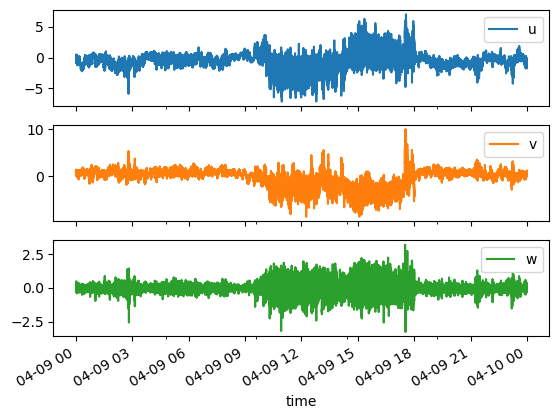

In [ ]:
fast_df_sail[['u','v','w']].plot(subplots=True)

Calculate 30-minute mean u, v, w, and 30-min wind direction, plot it

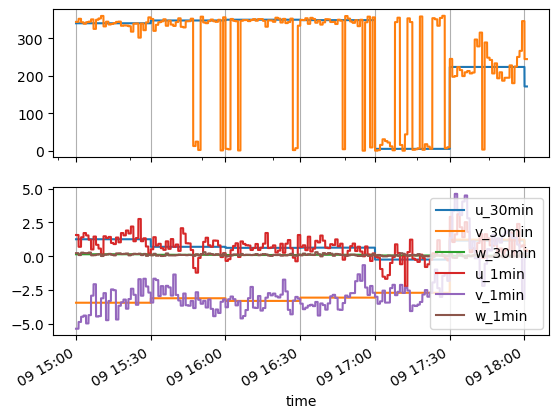

In [ ]:
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sail['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_30min'], -fast_df_sail['v_30min']))
fast_df_sail['dir_30min'] = fast_df_sail['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_sail['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_1min'], -fast_df_sail['v_1min']))
fast_df_sail['dir_1min'] = fast_df_sail['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fig, axes = plt.subplots(2,1)
fast_df_sail['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
fast_df_sail[['u_1min','v_1min','w_1min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [ ]:
fast_df_sail = fast_df_sail.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.052152292960355 2.1537263368826908e-16 -0.02342358224140048
Means after 2nd rotation: 1.0524129948773688 2.1537263368826908e-16 5.23475151325654e-18
Means after 1st rotation: 0.7870080929568921 1.2938978055041528e-16 -0.015530760004552498
Means after 2nd rotation: 0.7871613194802977 1.2938978055041528e-16 2.05281863373255e-18
Means after 1st rotation: 0.8832327418203677 2.400714548070693e-17 -0.015232066025533862
Means after 2nd rotation: 0.8833640767310672 2.400714548070693e-17 -3.1259304011337146e-19
Means after 1st rotation: 1.5140026377768838 -2.2312239691627377e-16 0.017132142919725934
Means after 2nd rotation: 1.5140995665795505 -2.2312239691627377e-16 1.6186334597720753e-18
Means after 1st rotation: 2.225014670815058 2.563288191642993e-16 0.028736579737715894
Means after 2nd rotation: 2.2252002328683282 2.563288191642993e-16 1.001284449860544e-18
Means after 1st rotation: 2.5062072157844573 -9.603703194455566e-17 0.09051301004021368
Means after 2nd ro

In [ ]:
fast_df_sail.index = fast_df_sail.index.get_level_values(1)

In [ ]:
fast_df_sail['u'] = fast_df_sail['u'].interpolate()
fast_df_sail['v'] = fast_df_sail['v'].interpolate()
fast_df_sail['w'] = fast_df_sail['w'].interpolate()

In [ ]:
def find_root(result, autocorr_col, time_col):
    # Assuming `data` is your DataFrame
    # Replace `data` with the actual DataFrame variable
    column_0 = result[autocorr_col]  # Extract column 0
    lag_s = result[time_col]     # Extract 'lag (s)' column

    # Find indices where column 0 changes sign
    sign_changes = np.where(np.diff(np.sign(column_0)))[0]

    if len(sign_changes) > 0:
        # Get the first root
        idx = sign_changes[0]
        print(f"The first root is at lag (s): {lag_s[idx]}")
        return idx
        # # Linear interpolation to find the root
        # x1, x2 = lag_s.iloc[idx], lag_s.iloc[idx + 1]
        # y1, y2 = column_0.iloc[idx], column_0.iloc[idx + 1]
        # root = x1 - y1 * (x2 - x1) / (y2 - y1)
        print(f"The first root is at lag (s): {root}")
    else:
        print("No root found in column 0.")

Calculate MRD

In [ ]:
mrd_uw_sail = fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 114022. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114022, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 47.13it/s]


Got data of length 114232. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114232, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 19032.58it/s]


Got data of length 113672. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 113672, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 20217.57it/s]


Got data of length 114134. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114134, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 19463.13it/s]


Got data of length 113541. using M = 16
Timestep of fast data is: 0.0 ms
Dataset of length 113541, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 14126.20it/s]


Got data of length 113643. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 113643, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 16690.98it/s]


Got data of length 113951. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 113951, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 22615.88it/s]


Got data of length 114204. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 114204, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 24001.74it/s]


In [ ]:
mrd_uw_sail.hour_group = mrd_uw_sail.hour_group.str.replace('2023-04-18 ', '')

In [ ]:
daily_mrd_sail_chart = alt.Chart(
    mrd_uw_sail.reset_index().query("tau > 0")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='sail')
daily_mrd_sail_chart

alt.Chart(...)

In [ ]:
mrd_uw_sail['time range'] = mrd_uw_sail.start_time.astype(str) + ' - ' + mrd_uw_sail.end_time.astype(str)

In [ ]:
alt.Chart(mrd_uw_sail.reset_index().query("tau > 0")).mark_line(strokeWidth=1).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('hour_group:O').scale(scheme='rainbow'),
    detail = 'time range'
).properties(width=300, height=300)

alt.Chart(...)

# SPLASH EC data

In [ ]:
splash_files = np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.*.nc")
    ) if d in f]
    for d in DATES
]).flatten()
fast_df_splash = xr.open_mfdataset(splash_files).to_dataframe().rename(columns={
    'metek_u': 'u',
    'metek_v': 'v',
    'metek_w': 'w',
})

In [ ]:
fast_df_splash = utils.modify_df_timezone(fast_df_splash.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_splash = fast_df_splash.loc[DATE_LOCAL]

In [ ]:
fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_splash['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_30min'], -fast_df_splash['v_30min']))
fast_df_splash['dir_30min'] = fast_df_splash['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_splash['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_1min'], -fast_df_splash['v_1min']))
fast_df_splash['dir_1min'] = fast_df_splash['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

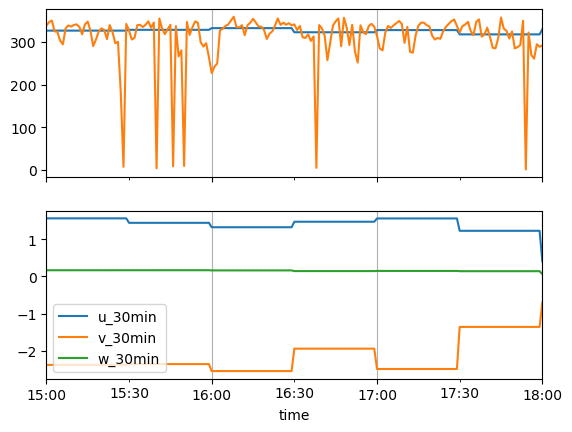

In [ ]:
fast_df_splash_30min = fast_df_splash.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_splash_30min['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [ ]:
fast_df_splash = fast_df_splash.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.3538588194807863 2.963902659408984e-17 0.07672280785342407
Means after 2nd rotation: 1.3560310071421016 2.963902659408984e-17 -2.7786587431959227e-17
Means after 1st rotation: 0.9711624689202675 -6.655611245678831e-17 0.06949709110510383
Means after 2nd rotation: 0.9736459247135891 -6.655611245678831e-17 -5.292732600937441e-19
Means after 1st rotation: 1.1529789596388225 -2.1170733281492745e-18 0.05271839685435719
Means after 2nd rotation: 1.1541835689077866 -2.1170733281492745e-18 -1.2570122885886316e-18
Means after 1st rotation: 2.768282722991057 -5.927805318817968e-17 0.1681559590848792
Means after 2nd rotation: 2.773385234868488 -5.927805318817968e-17 -1.4753354755540254e-17
Means after 1st rotation: 3.074640276189883 -5.335024786936171e-16 0.19292470702175288
Means after 2nd rotation: 3.080687061443994 -5.335024786936171e-16 4.101829573289219e-18
Means after 1st rotation: 2.6115937834206875 1.2702676517806591e-17 0.15606333943624132
Means after 2nd rota

In [ ]:
fast_df_splash.index = fast_df_splash.index.get_level_values(1)

In [ ]:
fast_df_splash['u'] = fast_df_splash['u'].interpolate()
fast_df_splash['v'] = fast_df_splash['v'].interpolate()
fast_df_splash['w'] = fast_df_splash['w'].interpolate()

Calculate MRD

In [ ]:
mrd_uw_splash = fast_df_splash.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 6486.04it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 14704.57it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 16152.65it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 13923.55it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 21519.76it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 16329.33it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 22538.48it/s]


Got data of length 108000. using M = 16
Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 17630.18it/s]


In [ ]:
mrd_uw_splash.hour_group = mrd_uw_splash.hour_group.str.replace('2023-04-18 ', '')

In [ ]:
alt.Chart(mrd_uw_splash.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)

In [ ]:
mrd_uw_splash.hour_group.unique()

array(['2023-04-09 00:00:00 - 2023-04-09 02:59:59.900000',
       '2023-04-09 03:00:00 - 2023-04-09 05:59:59.900000',
       '2023-04-09 06:00:00 - 2023-04-09 08:59:59.900000',
       '2023-04-09 09:00:00 - 2023-04-09 11:59:59.900000',
       '2023-04-09 12:00:00 - 2023-04-09 14:59:59.900000',
       '2023-04-09 15:00:00 - 2023-04-09 17:59:59.900000',
       '2023-04-09 18:00:00 - 2023-04-09 20:59:59.900000',
       '2023-04-09 21:00:00 - 2023-04-09 23:59:59.900000'], dtype=object)

In [ ]:
daily_mrd_splash_chart = alt.Chart(
    mrd_uw_splash.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='splash')
daily_mrd_splash_chart

alt.Chart(...)

# SOS EC data

Open data, average from 20hz to 10hz

In [4]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos_all_data = fast_data_files_to_dataframe(
    sos_file_list,  #CORRECT THIS
    rotation='none'
)

In [5]:
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]

In [39]:
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

In [40]:
fast_df_sos['dir'] = np.rad2deg(np.arctan2(-fast_df_sos['u'], -fast_df_sos['v']))

# Create 30min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sos['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_30min'], -fast_df_sos['v_30min']))
fast_df_sos['dir_30min'] = fast_df_sos['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

# Create 1min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sos['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_1min'], -fast_df_sos['v_1min']))
fast_df_sos['dir_1min'] = fast_df_sos['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

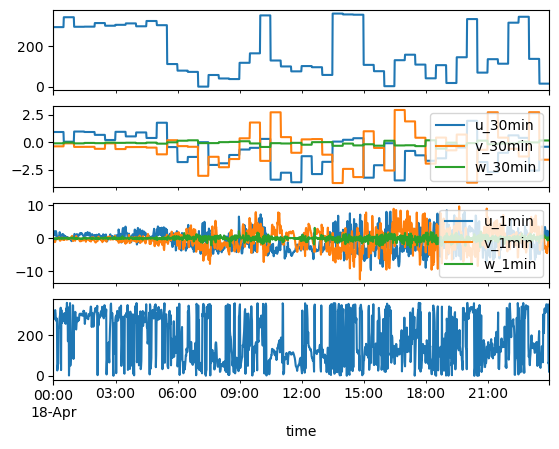

In [41]:
fast_df_sos_1min = fast_df_sos.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(4,1)
fast_df_sos_1min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sos_1min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
fast_df_sos_1min[['u_1min','v_1min','w_1min']].plot(ax=axes[2])
fast_df_sos_1min['dir_1min'].plot(ax=axes[3], sharex=True)
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply rotation into a given wind direction

In [42]:
# import numpy as np

# def project_winds(u, v):
#     # Convert -45 degrees to radians
#     angle = np.radians(-45)
#     print(angle)
#     # Define the rotation matrix
#     rotation_matrix = np.array([
#         [np.cos(angle), -np.sin(angle)],
#         [np.sin(angle), np.cos(angle)]
#     ])
#     print(rotation_matrix)
#     # Original wind vector
#     wind_vector = np.array([u, v])
#     print(wind_vector)
#     # Projected wind vector
#     projected_vector = rotation_matrix @ wind_vector
#     print(projected_vector)
#     return projected_vector

# # Example usage
# u = 10  # Westerly wind component
# v = 5   # Southerly wind component
# projected = project_winds(u, v)
# print("Projected winds:", projected)

In [43]:
# src = fast_df_sos.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1501']
# u, v = project_winds(
#     src['u'],
#     src['v']
# )
# src['u_proj'] = u 
# src['v_proj'] = v
# src['dir_proj'] = np.rad2deg(np.arctan2(-src['u_proj'], -src['v_proj']))

In [44]:
# src[['u', 'v', 'dir']].plot(subplots=True)

In [45]:
# src[['u_proj', 'v_proj', 'dir_proj']].plot(subplots=True)

Apply double rotation to 3hr chunks

In [46]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 0.7072692 5.6514033e-09 -0.078165255
Means after 2nd rotation: 0.7115752 5.6514033e-09 -1.7660636e-08
Means after 1st rotation: 0.8344015 -7.911964e-09 -0.069728866
Means after 2nd rotation: 0.83730996 -7.911964e-09 4.662408e-09
Means after 1st rotation: 2.0468357 5.334925e-07 0.022104852
Means after 2nd rotation: 2.046955 5.334925e-07 -2.2605613e-09
Means after 1st rotation: 1.8454545 -4.5211226e-09 -0.12739997
Means after 2nd rotation: 1.8498465 -4.5211226e-09 -1.2998227e-08
Means after 1st rotation: 1.8847866 -8.1662776e-08 -0.16741377
Means after 2nd rotation: 1.8922077 -8.1662776e-08 2.4018464e-08
Means after 1st rotation: 1.8927572 -4.973235e-08 -0.22447595
Means after 2nd rotation: 1.9060218 -4.973235e-08 1.1302807e-08
Means after 1st rotation: 1.1793259 4.5211227e-08 -0.12219572
Means after 2nd rotation: 1.1856397 4.5211227e-08 -1.1302806e-09
Means after 1st rotation: 1.0253481 -2.1249276e-07 -0.046001524
Means after 2nd rotation: 1.0263792 -2.1249276e

In [47]:
fast_df_sos.index = fast_df_sos.index.get_level_values(1)

In [48]:
fast_df_sos['u'] = fast_df_sos['u'].interpolate()
fast_df_sos['v'] = fast_df_sos['v'].interpolate()
fast_df_sos['w'] = fast_df_sos['w'].interpolate()

Calculate MRD

In [49]:
mrd_uu_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'u', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_vv_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'v', 'v', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_ww_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'w', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.00it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.13it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.03it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.02it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.08it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.22it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.06it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.05it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.07it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:28<00:00,  1.46it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.06it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.89it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.89it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [32:34<00:00, 46.55s/it]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.12it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.04it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.09it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [1:00:20<00:00, 86.20s/it]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.98it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.82it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:06<00:00,  6.08it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.76it/s]


In [6]:
alt.Chart(
    mrd_uu_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m uu') | alt.Chart(
    mrd_vv_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m vv') | alt.Chart(
    mrd_ww_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m ww')

NameError: name 'mrd_uu_sos' is not defined

In [ ]:
mrd_uw_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.65it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.49it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.32it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.37it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:08<00:00,  5.19it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.80it/s]


Got data of length 216000. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:08<00:00,  4.71it/s]


In [ ]:
mrd_uw_sos.hour_group = mrd_uw_sos.hour_group.str.replace('2023-04-09 ', '')

In [ ]:
daily_mrd_sos_chart = alt.Chart(
    mrd_uw_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q').scale(domain = [-0.1, 0.05]),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='sos')
daily_mrd_sos_chart

alt.Chart(...)

# Plot three sites comparison plot

In [ ]:
(
    daily_mrd_splash_chart & daily_mrd_sail_chart & daily_mrd_sos_chart
).resolve_scale(
    color='independent',
    x='shared',
    y='shared'
)

alt.VConcatChart(...)

# Calculate MRDs for April 18 1500-1800, at SOS, multiple heights

In [27]:
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1800': f'{DATE_LOCAL} 2100']
fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1200': f'{DATE_LOCAL} 1500']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 0000': f'{DATE_LOCAL} 0300']

In [28]:
mrds_df_ls = []
for h in [3,5,10,15,20]:
    print(f"Processing height: {h}m")
    fast_df_sos_oneheight = fast_df_sos_1500_1800[[f'u_{h}m_c', f'v_{h}m_c', f'w_{h}m_c']].rename(columns={
        f'u_{h}m_c': 'u',
        f'v_{h}m_c': 'v',
        f'w_{h}m_c': 'w',
    })
    fast_df_sos_oneheight = FastDataSAIL.double_rotation(fast_df_sos_oneheight, 'u', 'v', 'w')
    fast_df_sos_oneheight['u'] = fast_df_sos_oneheight['u'].interpolate()
    fast_df_sos_oneheight['v'] = fast_df_sos_oneheight['v'].interpolate()
    fast_df_sos_oneheight['w'] = fast_df_sos_oneheight['w'].interpolate()
    mrds_df_ls.append(
        calculate_mrd_for_df(
            fast_df_sos_oneheight.reset_index(), 'u', 'w', shift=2000, parallelism=20
        ).assign(
            height = h
        )
    )

Processing height: 3m
Means after 1st rotation: 1.9489089 -1.7534963e-07 -0.010246838
Means after 2nd rotation: 1.9489357 -1.7534963e-07 -1.405045e-10
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  6.00it/s]


Processing height: 5m
Means after 1st rotation: 2.0392215 6.969023e-08 -0.019799529
Means after 2nd rotation: 2.0393178 6.969023e-08 9.273297e-09
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  6.05it/s]


Processing height: 10m
Means after 1st rotation: 1.8999861 -1.899621e-07 -0.07571541
Means after 2nd rotation: 1.9014943 -1.899621e-07 -1.278591e-08
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:08<00:00,  4.88it/s]


Processing height: 15m
Means after 1st rotation: 1.853797 -1.3319827e-07 -0.11087868
Means after 2nd rotation: 1.8571101 -1.3319827e-07 1.8827603e-08
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  6.09it/s]


Processing height: 20m
Means after 1st rotation: 1.8875023 -3.4845115e-08 -0.16564526
Means after 2nd rotation: 1.894757 -3.4845115e-08 7.446739e-09
Got data of length 217200. using M = 17
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:08<00:00,  5.34it/s]


In [29]:
alt.Chart(
    pd.concat(mrds_df_ls).query("height > 2")
).mark_line(point=True).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('height:O'),
    tooltip = 'height:O',
)

alt.Chart(...)

## Rotate into pre-determined wind direction

In [ ]:
def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df

In [ ]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos_all_data = fast_data_files_to_dataframe(sos_file_list, rotation='none')
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

# Calculate integral length scales for all datasets

## For discreet periods

In [233]:
time_period = ('20230418 0600', '20230418 0701')

The first root is at lag (s): 161.1
The integration result_sail is: 39.563783761909534
The mean wind speed is: 3.5735382866235015
The integral length scale is: 141.3826960368769
The first root is at lag (s): 124.8
The integration result_splash is: 40.499447309649554
The mean wind speed is: 6.393155312479531
The integral length scale is: 258.9192567201709
The first root is at lag (s): 189.5
The integration result_sos is: 48.35620368530581
The mean wind speed is: 4.202324867248535
The integral length scale is: 203.20847723249585


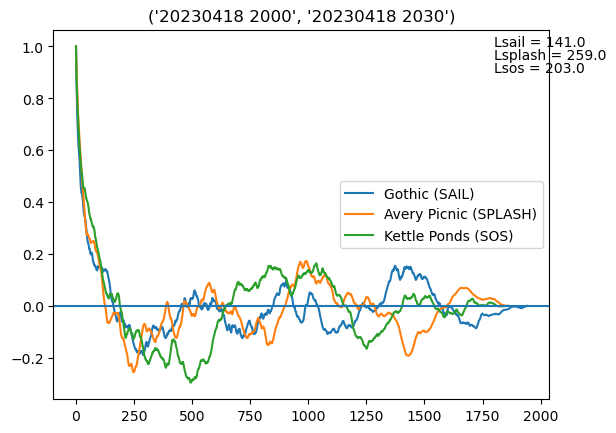

The first root is at lag (s): 172.8
The integration result_sail is: 64.68765664633176
The mean wind speed is: 1.0286166062727402
The integral length scale is: 66.53879784728605
The first root is at lag (s): 243.7
The integration result_splash is: 54.311275115268785
The mean wind speed is: 1.5075861918540965
The integral length scale is: 81.87892842576822
The first root is at lag (s): 352.05
The integration result_sos is: 151.6712481758099
The mean wind speed is: 1.4890872240066528
The integral length scale is: 225.85171790774086


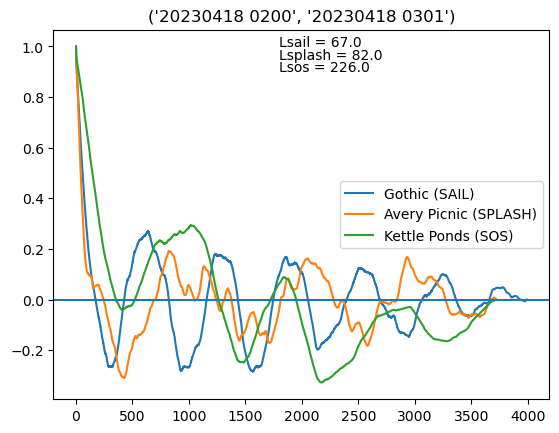

The first root is at lag (s): 692.0
The integration result_sail is: 133.6788580543261
The mean wind speed is: 2.046840443694686
The integral length scale is: 273.6192931325158
The first root is at lag (s): 170.2
The integration result_splash is: 39.99582694117818
The mean wind speed is: 2.381200096360396
The integral length scale is: 95.2380669663472
The first root is at lag (s): 1000.65
The integration result_sos is: 140.8069570158992
The mean wind speed is: 2.2385683059692383
The integral length scale is: 315.2059912357648


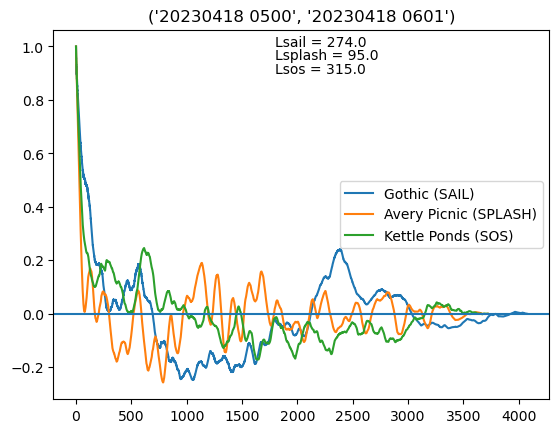

The first root is at lag (s): 108.6
The integration result_sail is: 25.84450514183327
The mean wind speed is: 2.4584189116299626
The integral length scale is: 63.53662020240072
The first root is at lag (s): 197.9
The integration result_splash is: 59.42853630666448
The mean wind speed is: 3.329652575258313
The integral length scale is: 197.87637895731754
The first root is at lag (s): 204.5
The integration result_sos is: 48.50439400441101
The mean wind speed is: 3.355607509613037
The integral length scale is: 162.76170877043117


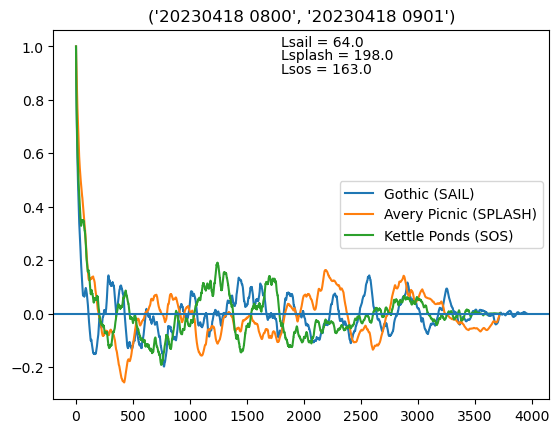

The first root is at lag (s): 156.5
The integration result_sail is: 49.35417311411862
The mean wind speed is: 2.340100352624932
The integral length scale is: 115.49371790786093
The first root is at lag (s): 968.0
The integration result_splash is: 221.66183768645033
The mean wind speed is: 3.4070301734240362
The integral length scale is: 755.2085692943574
The first root is at lag (s): 334.0
The integration result_sos is: 98.63013169201876
The mean wind speed is: 3.3873581886291504
The integral length scale is: 334.0955842325312


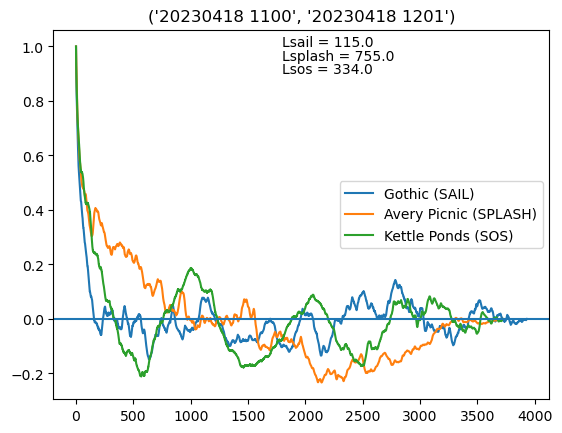

The first root is at lag (s): 152.2
The integration result_sail is: 25.934518788876332
The mean wind speed is: 3.9800978395944777
The integral length scale is: 103.22192220252909
The first root is at lag (s): 193.0
The integration result_splash is: 66.84905697864448
The mean wind speed is: 4.2682742990240765
The integral length scale is: 285.33011181594435
The first root is at lag (s): 99.65
The integration result_sos is: 26.423318331355766
The mean wind speed is: 5.090715408325195
The integral length scale is: 134.5135937685144


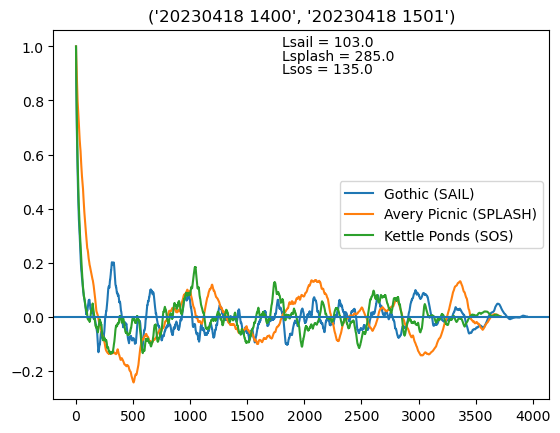

The first root is at lag (s): 932.8
The integration result_sail is: 216.61576093480673
The mean wind speed is: 3.691033752939126
The integral length scale is: 799.5360850289643
The first root is at lag (s): 160.0
The integration result_splash is: 57.94926162193797
The mean wind speed is: 4.22129697334933
The integral length scale is: 244.62104269251523
The first root is at lag (s): 72.6
The integration result_sos is: 19.648661513374826
The mean wind speed is: 5.2625732421875
The integral length scale is: 103.4025203250857


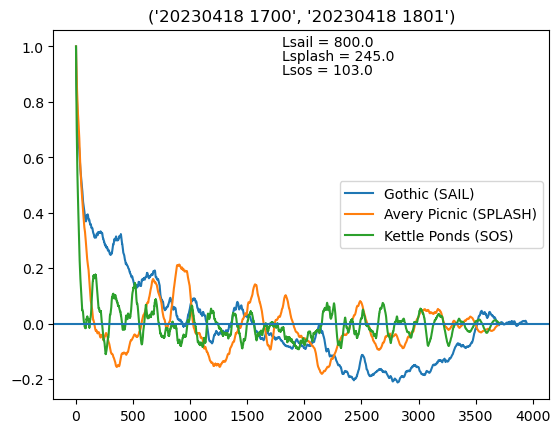

The first root is at lag (s): 237.6
The integration result_sail is: 57.06377359972293
The mean wind speed is: 2.989057716456316
The integral length scale is: 170.56691280836802
The first root is at lag (s): 727.1
The integration result_splash is: 106.98199793020062
The mean wind speed is: 5.559287477984441
The integral length scale is: 594.7436814631217
The first root is at lag (s): 290.8
The integration result_sos is: 64.35114690054762
The mean wind speed is: 4.330253601074219
The integral length scale is: 278.65678559935236


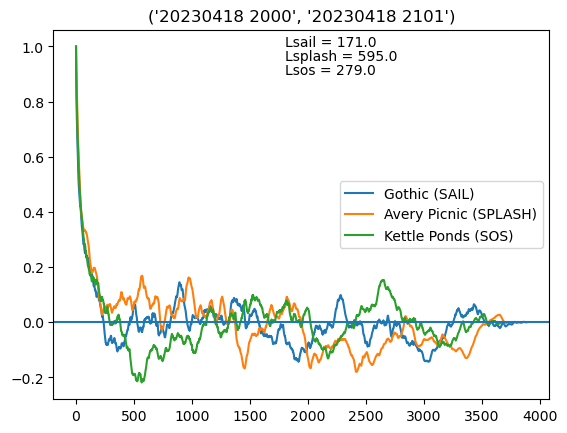

In [237]:
for time_period in [
    ('20230418 2000', '20230418 2030'),
    ('20230418 0200', '20230418 0301'),
    ('20230418 0500', '20230418 0601'),
    ('20230418 0800', '20230418 0901'),
    ('20230418 1100', '20230418 1201'),
    ('20230418 1400', '20230418 1501'),
    ('20230418 1700', '20230418 1801'),
    ('20230418 2000', '20230418 2101'),
]:
    # SAIL
    src_sail = fast_df_sail.loc[time_period[0]: time_period[1]]
    src_sail = src_sail.assign(
        spd = np.sqrt(src_sail['u']**2 + src_sail['v']**2)
    )
    spd_corr_result_sail = np.correlate(
        src_sail['spd'] - src_sail['spd'].mean(), 
        src_sail['spd'] - src_sail['spd'].mean(), 
        mode='full'
    )
    result_sail = spd_corr_result_sail[spd_corr_result_sail.size // 2:]
    result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
    result_sail['lag (s)'] = result_sail.index/10

    first_root_sail = find_root(result_sail, 'R',  'lag (s)')
    integral_result_sail = np.trapz(
        result_sail['R'].loc[:first_root_sail],
        result_sail['lag (s)'].loc[:first_root_sail],
    )
    integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())
    print(f'The integration result_sail is: {integral_result_sail}')
    print(f'The mean wind speed is: {src_sail['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sail}")


    # SPLASH
    src_splash = fast_df_splash.loc[time_period[0]: time_period[1]]
    src_splash = src_splash.assign(
        spd = np.sqrt(src_splash['u']**2 + src_splash['v']**2)
    )
    spd_corr_result_splash = np.correlate(
        src_splash['spd'] - src_splash['spd'].mean(), 
        src_splash['spd'] - src_splash['spd'].mean(), 
        mode='full'
    )
    result_splash = spd_corr_result_splash[spd_corr_result_splash.size // 2:]
    result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
    result_splash['lag (s)'] = result_splash.index/10

    first_root_splash = find_root(result_splash, 'R',  'lag (s)')
    integral_result_splash = np.trapz(
        result_splash['R'].loc[:first_root_splash],
        result_splash['lag (s)'].loc[:first_root_splash],
    )
    integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())
    print(f'The integration result_splash is: {integral_result_splash}')
    print(f'The mean wind speed is: {src_splash['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_splash}")


    # SOS
    src_sos = fast_df_sos.loc[time_period[0]: time_period[1]]
    src_sos = src_sos.assign(
        spd = np.sqrt(src_sos['u']**2 + src_sos['v']**2)
    )
    spd_corr_result_sos = np.correlate(
        src_sos['spd'] - src_sos['spd'].mean(), 
        src_sos['spd'] - src_sos['spd'].mean(), 
        mode='full'
    )
    result_sos = spd_corr_result_sos[spd_corr_result_sos.size // 2:]
    result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
    result_sos['lag (s)'] = result_sos.index/20

    first_root_sos = find_root(result_sos, 'R',  'lag (s)')
    integral_result_sos = np.trapz(
        result_sos['R'].loc[:first_root_sos],
        result_sos['lag (s)'].loc[:first_root_sos],
    )
    integral_length_scale_sos = integral_result_sos * src_sos['spd'].mean()
    print(f'The integration result_sos is: {integral_result_sos}')
    print(f'The mean wind speed is: {src_sos['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sos}")

    plt.plot(result_sail['lag (s)'], result_sail["R"], label='Gothic (SAIL)')
    plt.plot(result_splash['lag (s)'], result_splash["R"], label='Avery Picnic (SPLASH)')
    plt.plot(result_sos['lag (s)'], result_sos["R"], label='Kettle Ponds (SOS)')
    plt.text(x=1800, y=1, s = f"Lsail = {round(integral_length_scale_sail,0)}")
    plt.text(x=1800, y=0.95, s = f"Lsplash = {round(integral_length_scale_splash,0)}")
    plt.text(x=1800, y=0.9, s = f"Lsos = {round(integral_length_scale_sos,0)}")
    plt.title(time_period)
    plt.axhline(0)
    plt.legend()
    plt.show()

## For entire day, using moving window averages

In [324]:
src_sail_wholeday = fast_df_sail.assign(
    spd = np.sqrt(fast_df_sail['u']**2 + fast_df_sail['v']**2)
)
src_sail_wholeday['spd_fluc'] = src_sail_wholeday['spd'] - src_sail_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sail_wholeday = np.correlate(
    src_sail_wholeday['spd_fluc'],
    src_sail_wholeday['spd_fluc'],
    mode='full'
)


In [325]:
src_splash_wholeday = fast_df_splash.assign(
    spd = np.sqrt(fast_df_splash['u']**2 + fast_df_splash['v']**2)
)
src_splash_wholeday['spd_fluc'] = src_splash_wholeday['spd'] - src_splash_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_splash_wholeday = np.correlate(
    src_splash_wholeday['spd_fluc'],
    src_splash_wholeday['spd_fluc'],
    mode='full'
)


In [326]:
src_sos_wholeday = fast_df_sos.assign(
    spd = np.sqrt(fast_df_sos['u']**2 + fast_df_sos['v']**2)
)
src_sos_wholeday['spd_fluc'] = src_sos_wholeday['spd'] - src_sos_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sos_wholeday = np.correlate(
    src_sos_wholeday['spd_fluc'],
    src_sos_wholeday['spd_fluc'],
    mode='full'
)


In [327]:
result_sail = spd_corr_result_sail_wholeday[spd_corr_result_sail_wholeday.size // 2:]
result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
result_sail['lag_s'] = result_sail.index/10
first_root_sail = find_root(result_sail, 'R',  'lag_s')
integral_result_sail = np.trapz(
    result_sail['R'].loc[:first_root_sail],
    result_sail['lag_s'].loc[:first_root_sail],
)
integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())


result_splash = spd_corr_result_splash_wholeday[spd_corr_result_splash_wholeday.size // 2:]
result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
result_splash['lag_s'] = result_splash.index/10
first_root_splash = find_root(result_splash, 'R',  'lag_s')
integral_result_splash = np.trapz(
    result_splash['R'].loc[:first_root_splash],
    result_splash['lag_s'].loc[:first_root_splash],
)
integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())


result_sos = spd_corr_result_sos_wholeday[spd_corr_result_sos_wholeday.size // 2:]
result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
result_sos['lag_s'] = result_sos.index/20
first_root_sos = find_root(result_sos, 'R',  'lag_s')
integral_result_sos = np.trapz(
    result_sos['R'].loc[:first_root_sos],
    result_sos['lag_s'].loc[:first_root_sos],
)
integral_length_scale_sos = (integral_result_sos * src_sos['spd'].mean())

The first root is at lag (s): 1003.5
The first root is at lag (s): 1239.5
The first root is at lag (s): 1108.5


In [328]:
alt.Chart(result_sail.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sail, 1)}') | alt.Chart(result_splash.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_splash, 1)}') | alt.Chart(result_sos.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sos, 1)}')

alt.HConcatChart(...)